### 데이터 불러오기

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving SeatMap.v1i.yolov8.zip to SeatMap.v1i.yolov8.zip


In [ ]:
import zipfile
import os

zip_path = "/content/SeatMap.v1i.yolov8.zip"
extract_dir = "/content/SeatMap.v1i.yolov8"

# 압축 해제
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

### 데이터 분할 및 증강 후 병합

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# 기존 데이터 경로
base_path = '/content/SeatMap.v1i.yolov8'
img_dir = os.path.join(base_path, 'train/images')
lbl_dir = os.path.join(base_path, 'train/labels')

# 출력 경로
train_img_dir = os.path.join(base_path, 'images/train')
val_img_dir   = os.path.join(base_path, 'images/val')
train_lbl_dir = os.path.join(base_path, 'labels/train')
val_lbl_dir   = os.path.join(base_path, 'labels/val')

# 디렉토리 생성
for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# 이미지 파일 리스트
img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]

# 학습/검증 분할
train_imgs, val_imgs = train_test_split(img_files, test_size=0.2, random_state=42)

def move_data(file_list, src_img_dir, src_lbl_dir, dst_img_dir, dst_lbl_dir):
    for f in file_list:
        img_src = os.path.join(src_img_dir, f)
        lbl_src = os.path.join(src_lbl_dir, os.path.splitext(f)[0] + '.txt')

        img_dst = os.path.join(dst_img_dir, f)
        lbl_dst = os.path.join(dst_lbl_dir, os.path.splitext(f)[0] + '.txt')

        shutil.copyfile(img_src, img_dst)
        if os.path.exists(lbl_src):
            shutil.copyfile(lbl_src, lbl_dst)

# 이동 실행
move_data(train_imgs, img_dir, lbl_dir, train_img_dir, train_lbl_dir)
move_data(val_imgs, img_dir, lbl_dir, val_img_dir, val_lbl_dir)

print("기존 이미지/라벨 → train/val 분할 완료")

기존 이미지/라벨 → train/val 분할 완료


In [ ]:
import os

# 디렉토리 경로 설정
base_dir = '/content/SeatMap.v1i.yolov8/images'
subdirs = ['train', 'val']

# 이미지 확장자 정의 (YOLO에서 주로 사용되는 포맷들)
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# 각 폴더에 있는 이미지 개수 출력
for subdir in subdirs:
    folder_path = os.path.join(base_dir, subdir)
    image_count = len([
        f for f in os.listdir(folder_path)
        if os.path.splitext(f)[1].lower() in image_extensions
    ])
    print(f"{subdir} 이미지 개수: {image_count}장")

train 이미지 개수: 100장
val 이미지 개수: 25장


In [ ]:
import os
import cv2
import random
import albumentations as A
from tqdm import tqdm

# 디렉토리 설정
input_img_dir = '/content/SeatMap.v1i.yolov8/images/train'
input_lbl_dir = '/content/SeatMap.v1i.yolov8/labels/train'

output_img_dir = '/content/augmented/images'
output_lbl_dir = '/content/augmented/labels'
os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_lbl_dir, exist_ok=True)

# 클래스 수 (YOLO format assumes class indices)
class_names = ['empty', 'occupied']  # optional, for verification only

# 증강 파이프라인 (bbox 처리 포함)
augment = A.Compose([
    A.HorizontalFlip(p=0.4),                        # 단순하고 가벼움
    A.RandomBrightnessContrast(p=0.3),              # 조명/대비, GPU 부담 적음
    A.ShiftScaleRotate(shift_limit=0.05,
                       scale_limit=0.1,
                       rotate_limit=10, p=0.3),     # Rotate+Crop보다 가벼움
    A.Resize(224, 224)                              # 항상 고정 크기로 맞춤
],
bbox_params=A.BboxParams(format='yolo',
                         label_fields=['class_labels'],
                         min_visibility=0.3))

# 증강 횟수
AUG_PER_IMAGE = 2

image_files = [f for f in os.listdir(input_img_dir) if f.endswith(('.jpg', '.png'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(input_img_dir, img_file)
    label_path = os.path.join(input_lbl_dir, os.path.splitext(img_file)[0] + '.txt')

    # 이미지 로드
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w = image.shape[:2]

    # 라벨 로드
    bboxes = []
    class_labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                bboxes.append([x, y, bw, bh])
                class_labels.append(int(cls))
    else:
        continue  # 라벨 없으면 스킵

    # 증강 반복
    for i in range(AUG_PER_IMAGE):
        augmented = augment(image=image, bboxes=bboxes, class_labels=class_labels)
        aug_img = augmented['image']
        aug_bboxes = augmented['bboxes']
        aug_labels = augmented['class_labels']

        # 파일명 설정
        base_name = os.path.splitext(img_file)[0]
        aug_img_name = f"{base_name}_aug{i}.jpg"
        aug_lbl_name = f"{base_name}_aug{i}.txt"

        # 이미지 저장
        aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(output_img_dir, aug_img_name), aug_img_bgr)

        # 라벨 저장
        with open(os.path.join(output_lbl_dir, aug_lbl_name), 'w') as f:
            for label, box in zip(aug_labels, aug_bboxes):
                f.write(f"{label} {box[0]:.6f} {box[1]:.6f} {box[2]:.6f} {box[3]:.6f}\n")

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
100%|██████████| 100/100 [00:02<00:00, 33.89it/s]


시각화: KakaoTalk_20250814_121909506_11_jpg.rf.02709210a31a4c57ce6b433243ed783c_aug1.jpg


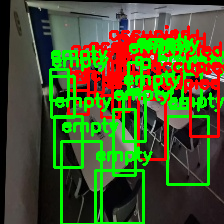

시각화: 20250813_153712_jpg.rf.7baced9cd6d3596c911001b78b6ee42b_aug0.jpg


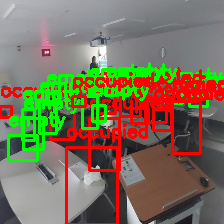

시각화: KakaoTalk_20250814_121909506_12_jpg.rf.79ece7c725e77b6f967fe486ae633ab6_aug0.jpg


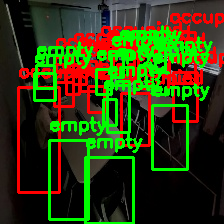

시각화: KakaoTalk_20250814_121909506_24_jpg.rf.2878a567350cc320ef97af489b55972c_aug0.jpg


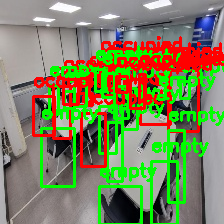

시각화: 20250813_152624_jpg.rf.9cc51a669d526e170852fd7b4db32fd2_aug1.jpg


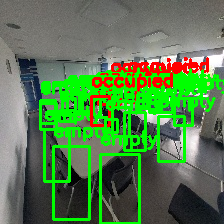

In [ ]:
import os
import random
import cv2
from google.colab.patches import cv2_imshow

# 증강된 이미지 및 라벨 경로
aug_img_dir = '/content/augmented/images'
aug_lbl_dir = '/content/augmented/labels'

# 클래스 이름 정의 (YOLO 라벨 인덱스 기준)
class_names = ['empty', 'occupied']  # 반드시 YOLO 클래스 순서와 일치

# 시각화할 이미지 수
NUM_SAMPLES = 5

# 이미지 파일 리스트
image_files = [f for f in os.listdir(aug_img_dir) if f.endswith(('.jpg', '.png'))]

# 무작위 샘플 선택
for img_file in random.sample(image_files, min(NUM_SAMPLES, len(image_files))):
    img_path = os.path.join(aug_img_dir, img_file)
    label_path = os.path.join(aug_lbl_dir, os.path.splitext(img_file)[0] + '.txt')

    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    if not os.path.exists(label_path):
        print(f"라벨 없음: {label_path}")
        continue

    # 라벨 읽기 및 바운딩박스 시각화
    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            color = (0, 255, 0) if int(cls) == 0 else (0, 0, 255)
            label = class_names[int(cls)]
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    print(f"시각화: {img_file}")
    cv2_imshow(image)

In [ ]:
import os
import shutil

# 소스 디렉토리 목록
image_sources = [
    '/content/SeatMap.v1i.yolov8/images/train',
    '/content/augmented/images'
]

label_sources = [
    '/content/SeatMap.v1i.yolov8/labels/train',
    '/content/augmented/labels'
]

# 대상 디렉토리
merged_image_dir = '/content/merged/images'
merged_label_dir = '/content/merged/labels'

# 확장자 설정
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
label_extension = '.txt'

# 대상 디렉토리 생성
os.makedirs(merged_image_dir, exist_ok=True)
os.makedirs(merged_label_dir, exist_ok=True)

# 이미지 + 라벨 병합
for img_src, lbl_src in zip(image_sources, label_sources):
    for filename in os.listdir(img_src):
        if os.path.splitext(filename)[1].lower() in image_extensions:
            base_name, ext = os.path.splitext(filename)

            src_img_path = os.path.join(img_src, filename)
            src_lbl_path = os.path.join(lbl_src, f"{base_name}{label_extension}")

            dst_img_path = os.path.join(merged_image_dir, filename)
            dst_lbl_path = os.path.join(merged_label_dir, f"{base_name}{label_extension}")

            # 이름 중복 방지
            counter = 1
            while os.path.exists(dst_img_path) or os.path.exists(dst_lbl_path):
                new_base = f"{base_name}_{counter}"
                dst_img_path = os.path.join(merged_image_dir, f"{new_base}{ext}")
                dst_lbl_path = os.path.join(merged_label_dir, f"{new_base}{label_extension}")
                counter += 1

            shutil.copy2(src_img_path, dst_img_path)

            if os.path.exists(src_lbl_path):
                shutil.copy2(src_lbl_path, dst_lbl_path)

print("모든 이미지와 라벨이 /content/merged 디렉토리로 병합 완료됨")

모든 이미지와 라벨이 /content/merged 디렉토리로 병합 완료됨


In [ ]:
import os

# 경로 설정
image_dir = '/content/merged/images'
label_dir = '/content/merged/labels'

# 확장자 설정
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
label_extension = '.txt'

# 이미지 개수 세기
image_count = len([
    f for f in os.listdir(image_dir)
    if os.path.splitext(f)[1].lower() in image_extensions
])

# 라벨 개수 세기
label_count = len([
    f for f in os.listdir(label_dir)
    if f.endswith(label_extension)
])

print(f"이미지 수: {image_count}장")
print(f"라벨 수: {label_count}개")

이미지 수: 300장
라벨 수: 300개


In [ ]:
import yaml

class_names = ['empty', 'occupied']

data = {
    'train': '/content/merged/images',
    'val': '/content/SeatMap.v1i.yolov8/images/val',
    'test': '/content/SeatMap.v1i.yolov8/images/val',  # 선택 사항
    'names': {i: name for i, name in enumerate(class_names)},
    'nc': len(class_names)
}

yaml_path = '/content/merged/dataset.yaml'

with open(yaml_path, 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

print(f"dataset.yaml 파일 생성 완료: {yaml_path}")


dataset.yaml 파일 생성 완료: /content/merged/dataset.yaml


### 학습 3 : AUG_PER_IMAGE = 2, epochs=50, lr0=0.001

In [ ]:
!pip install -q ultralytics

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
model.train(data='/content/merged/dataset.yaml', epochs=50, imgsz=640, lr0=0.001, device=0)

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/merged/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0

train: Scanning /content/merged/labels.cache... 300 images, 0 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 372.9±50.0 MB/s, size: 45.0 KB)


val: Scanning /content/SeatMap.v1i.yolov8/labels/val.cache... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.86G       2.37      3.266      1.783        457        640: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         25        702     0.0457      0.495      0.125      0.052



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.86G      2.017      1.935      1.403        322        640: 100%|██████████| 19/19 [00:01<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         25        702       0.39      0.274      0.255      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.86G      1.846      1.655       1.34        559        640: 100%|██████████| 19/19 [00:01<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         25        702      0.455      0.309      0.298      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.86G      1.735      1.498      1.307        457        640: 100%|██████████| 19/19 [00:01<00:00, 11.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         25        702       0.55      0.384      0.443      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.86G      1.709      1.443       1.29        681        640: 100%|██████████| 19/19 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         25        702       0.48      0.497      0.467      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.86G      1.636       1.35       1.27        527        640: 100%|██████████| 19/19 [00:01<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         25        702      0.575       0.45      0.538      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.86G      1.627      1.285      1.269        345        640: 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         25        702      0.606      0.424      0.506      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.86G      1.583      1.217      1.238        528        640: 100%|██████████| 19/19 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         25        702      0.727      0.606       0.72      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.86G      1.545       1.16      1.219        609        640: 100%|██████████| 19/19 [00:01<00:00, 11.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

                   all         25        702      0.774      0.624      0.717      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.86G       1.55      1.161      1.224        634        640: 100%|██████████| 19/19 [00:01<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         25        702      0.753      0.679      0.773      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.86G      1.519      1.133      1.222        453        640: 100%|██████████| 19/19 [00:01<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25        702      0.837      0.684      0.804      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.86G      1.474      1.089      1.196        539        640: 100%|██████████| 19/19 [00:01<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         25        702      0.819      0.731      0.824      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       3.1G      1.469      1.066      1.182        494        640: 100%|██████████| 19/19 [00:01<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         25        702      0.831       0.72      0.821      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       3.1G      1.484      1.074      1.192        592        640: 100%|██████████| 19/19 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         25        702      0.848      0.741      0.839       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       3.1G      1.433       1.02      1.174        333        640: 100%|██████████| 19/19 [00:01<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         25        702      0.824      0.751      0.836      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       3.1G      1.429      1.014      1.182        470        640: 100%|██████████| 19/19 [00:01<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         25        702      0.809      0.758      0.831      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.1G      1.402     0.9852      1.163        376        640: 100%|██████████| 19/19 [00:01<00:00, 11.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         25        702       0.86       0.72      0.832      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       3.1G       1.39      0.966      1.161        565        640: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

                   all         25        702      0.852      0.774      0.855      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       3.1G      1.373     0.9619      1.151        509        640: 100%|██████████| 19/19 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         25        702      0.825      0.752      0.842      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.1G      1.378     0.9508      1.153        508        640: 100%|██████████| 19/19 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         25        702      0.836       0.79      0.868      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50       3.1G      1.351     0.9283      1.129        593        640: 100%|██████████| 19/19 [00:01<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         25        702      0.836      0.806      0.875      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50       3.1G      1.322     0.8995      1.122        546        640: 100%|██████████| 19/19 [00:01<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         25        702      0.842      0.766      0.863       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       3.1G      1.312     0.8971      1.124        624        640: 100%|██████████| 19/19 [00:01<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         25        702      0.863      0.798      0.876       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50       3.1G       1.32     0.9002      1.126        447        640: 100%|██████████| 19/19 [00:02<00:00,  9.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         25        702      0.892      0.776      0.881      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50       3.1G      1.348     0.8999      1.135        497        640: 100%|██████████| 19/19 [00:01<00:00, 11.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         25        702      0.865      0.797      0.883      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.1G      1.321     0.8751      1.119        573        640: 100%|██████████| 19/19 [00:01<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         25        702       0.87      0.804      0.888      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       3.1G      1.331     0.8827      1.136        488        640: 100%|██████████| 19/19 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         25        702      0.883       0.81      0.898      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.1G      1.293     0.8504      1.116        529        640: 100%|██████████| 19/19 [00:01<00:00, 11.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         25        702      0.878      0.808      0.891      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       3.1G      1.267      0.846      1.106        430        640: 100%|██████████| 19/19 [00:01<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         25        702      0.865      0.799      0.886      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50       3.1G      1.287     0.8357       1.11        507        640: 100%|██████████| 19/19 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


                   all         25        702      0.873       0.81      0.889      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50       3.1G       1.28      0.849       1.11        334        640: 100%|██████████| 19/19 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         25        702      0.893      0.813      0.896       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.1G      1.258     0.8257      1.106        537        640: 100%|██████████| 19/19 [00:01<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         25        702      0.897      0.805      0.891       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       3.1G      1.236     0.8104      1.093        593        640: 100%|██████████| 19/19 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         25        702      0.868      0.821      0.893      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50       3.1G      1.268     0.8158      1.094        480        640: 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.70it/s]

                   all         25        702      0.868      0.824      0.887      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50       3.1G      1.252      0.817      1.089        458        640: 100%|██████████| 19/19 [00:01<00:00, 10.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.50it/s]

                   all         25        702      0.888      0.803      0.885      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       3.1G      1.234     0.8093      1.096        641        640: 100%|██████████| 19/19 [00:01<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         25        702      0.891      0.809      0.889      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       3.1G      1.225      0.796      1.078        476        640: 100%|██████████| 19/19 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         25        702      0.903      0.798      0.889      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50       3.1G      1.222     0.7872      1.077        541        640: 100%|██████████| 19/19 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.91it/s]

                   all         25        702      0.907      0.801      0.897      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       3.1G      1.216     0.7855      1.082        330        640: 100%|██████████| 19/19 [00:01<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         25        702      0.881      0.799      0.882      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.1G      1.198     0.7741      1.072        529        640: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]

                   all         25        702      0.868      0.844      0.898      0.547


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.1G      1.182      0.765      1.077        329        640: 100%|██████████| 19/19 [00:02<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         25        702      0.874      0.817      0.889      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       3.1G      1.158     0.7445      1.078        324        640: 100%|██████████| 19/19 [00:01<00:00, 11.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         25        702      0.863      0.837      0.893      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       3.1G      1.143     0.7174      1.063        333        640: 100%|██████████| 19/19 [00:01<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         25        702      0.862       0.85      0.894      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       3.1G      1.111     0.7083      1.052        329        640: 100%|██████████| 19/19 [00:01<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         25        702      0.874      0.831      0.891      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       3.1G      1.105     0.6993      1.043        352        640: 100%|██████████| 19/19 [00:01<00:00, 11.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         25        702      0.899      0.824      0.893      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.1G      1.104     0.7008      1.048        314        640: 100%|██████████| 19/19 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25        702      0.872      0.823      0.886      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       3.1G      1.083     0.6886      1.045        334        640: 100%|██████████| 19/19 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         25        702      0.869      0.837      0.893       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       3.1G       1.09      0.689      1.036        315        640: 100%|██████████| 19/19 [00:01<00:00, 11.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         25        702      0.869      0.827      0.894      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.1G       1.06     0.6769      1.031        326        640: 100%|██████████| 19/19 [00:01<00:00, 11.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.73it/s]

                   all         25        702      0.866      0.831      0.893      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50       3.1G      1.058     0.6728      1.026        313        640: 100%|██████████| 19/19 [00:01<00:00, 12.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.84it/s]

                   all         25        702      0.863      0.839      0.896      0.548



50 epochs completed in 0.030 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]


                   all         25        702        0.9      0.823      0.893      0.553
                 empty         25        440      0.887      0.773      0.871      0.553
              occupied         25        262      0.913      0.874      0.915      0.553
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79e928928350>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

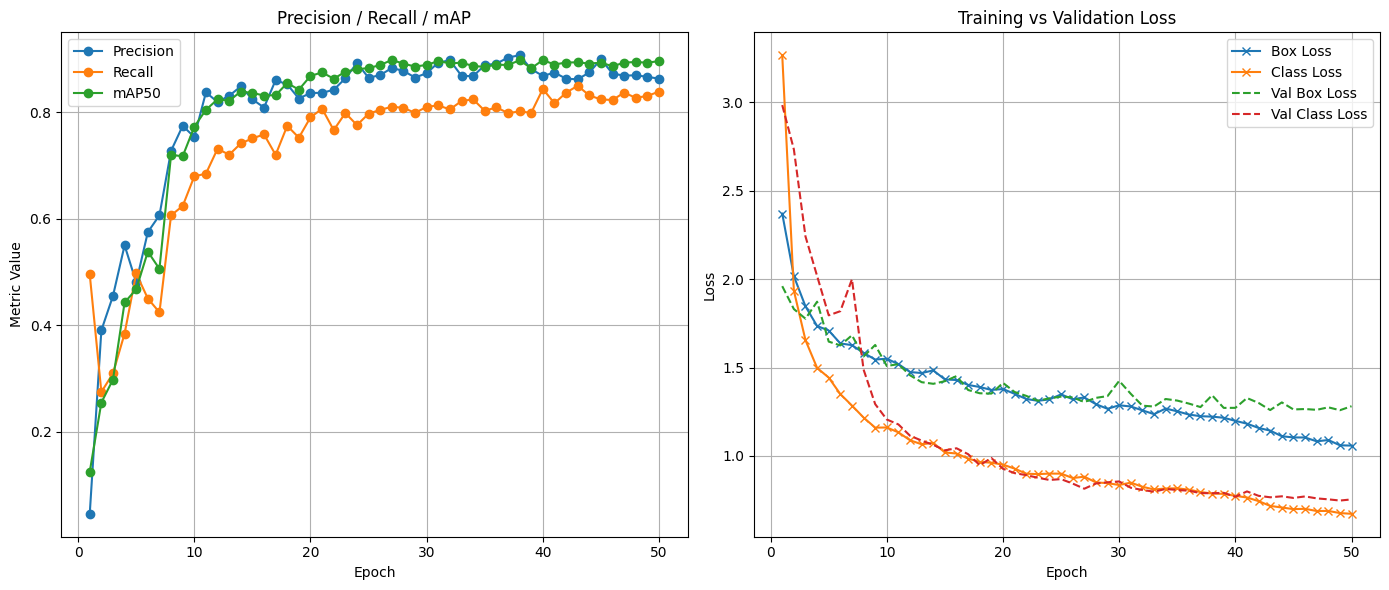

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 경로: YOLO 학습 결과 디렉토리
results_csv_path = "/content/runs/detect/train3/results.csv"

# CSV 불러오기
assert os.path.exists(results_csv_path), f"CSV 파일 없음: {results_csv_path}"
df = pd.read_csv(results_csv_path)

# 기본 정보
epochs = df.index + 1  # 0부터 시작하므로 +1

# 그래프 그리기
plt.figure(figsize=(14, 6))

# ---- Accuracy / Precision / Recall ----
plt.subplot(1, 2, 1)
plt.plot(epochs, df["metrics/precision(B)"], label="Precision", marker='o')
plt.plot(epochs, df["metrics/recall(B)"], label="Recall", marker='o')
plt.plot(epochs, df["metrics/mAP50(B)"], label="mAP50", marker='o')
plt.title("Precision / Recall / mAP")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.grid(True)
plt.legend()

# ---- Loss ----
plt.subplot(1, 2, 2)
plt.plot(epochs, df["train/box_loss"], label="Box Loss", marker='x')
plt.plot(epochs, df["train/cls_loss"], label="Class Loss", marker='x')
plt.plot(epochs, df["val/box_loss"], label="Val Box Loss", linestyle="--")
plt.plot(epochs, df["val/cls_loss"], label="Val Class Loss", linestyle="--")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from ultralytics import YOLO

# 학습된 모델 로드 (best.pt 또는 last.pt 선택 가능)
model = YOLO("runs/detect/train3/weights/best.pt")

# 검증 수행 (data.yaml 기반으로 val 세트 사용)
metrics = model.val()

# 결과 요약
print("검증 완료")
print(metrics)  # 내부적으로 mAP50, mAP50-95 등 포함

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1659.6±1004.5 MB/s, size: 496.3 KB)


val: Scanning /content/SeatMap.v1i.yolov8/labels/val.cache... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


                   all         25        702        0.9      0.824      0.894      0.551
                 empty         25        440      0.888      0.774      0.873      0.551
              occupied         25        262      0.913      0.874      0.915      0.551
Speed: 2.7ms preprocess, 1.4ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/val2
검증 완료
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79e5f00c2450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,

BoxPR_curve.png


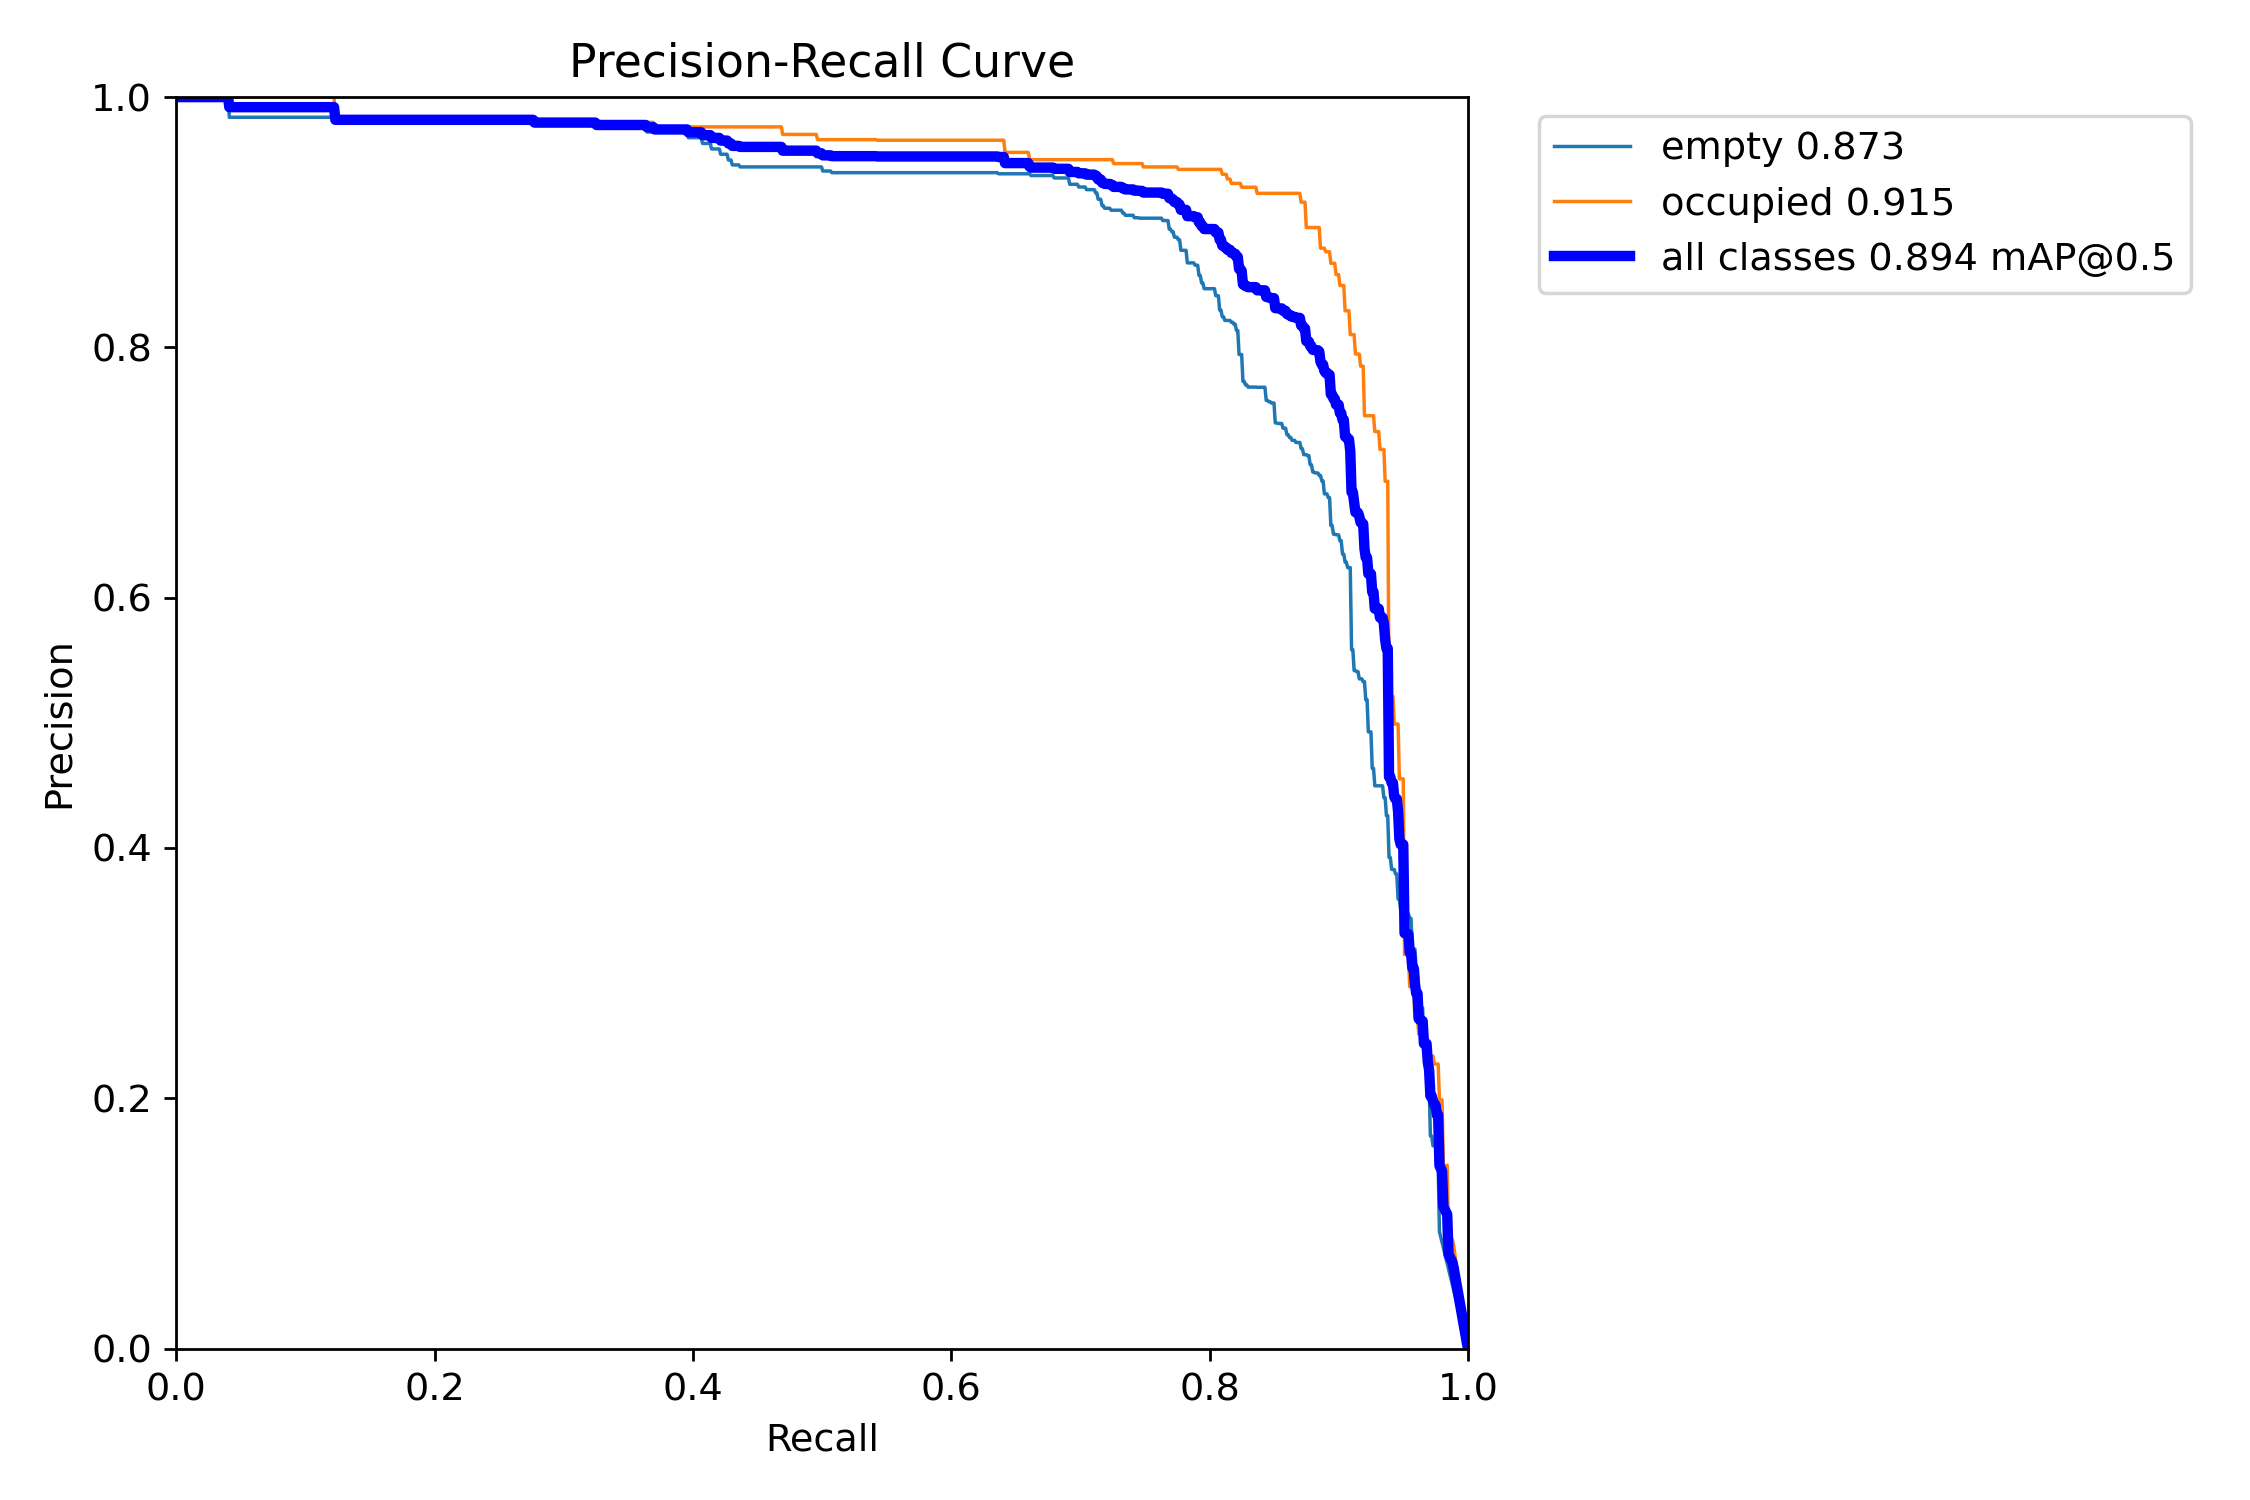

BoxP_curve.png


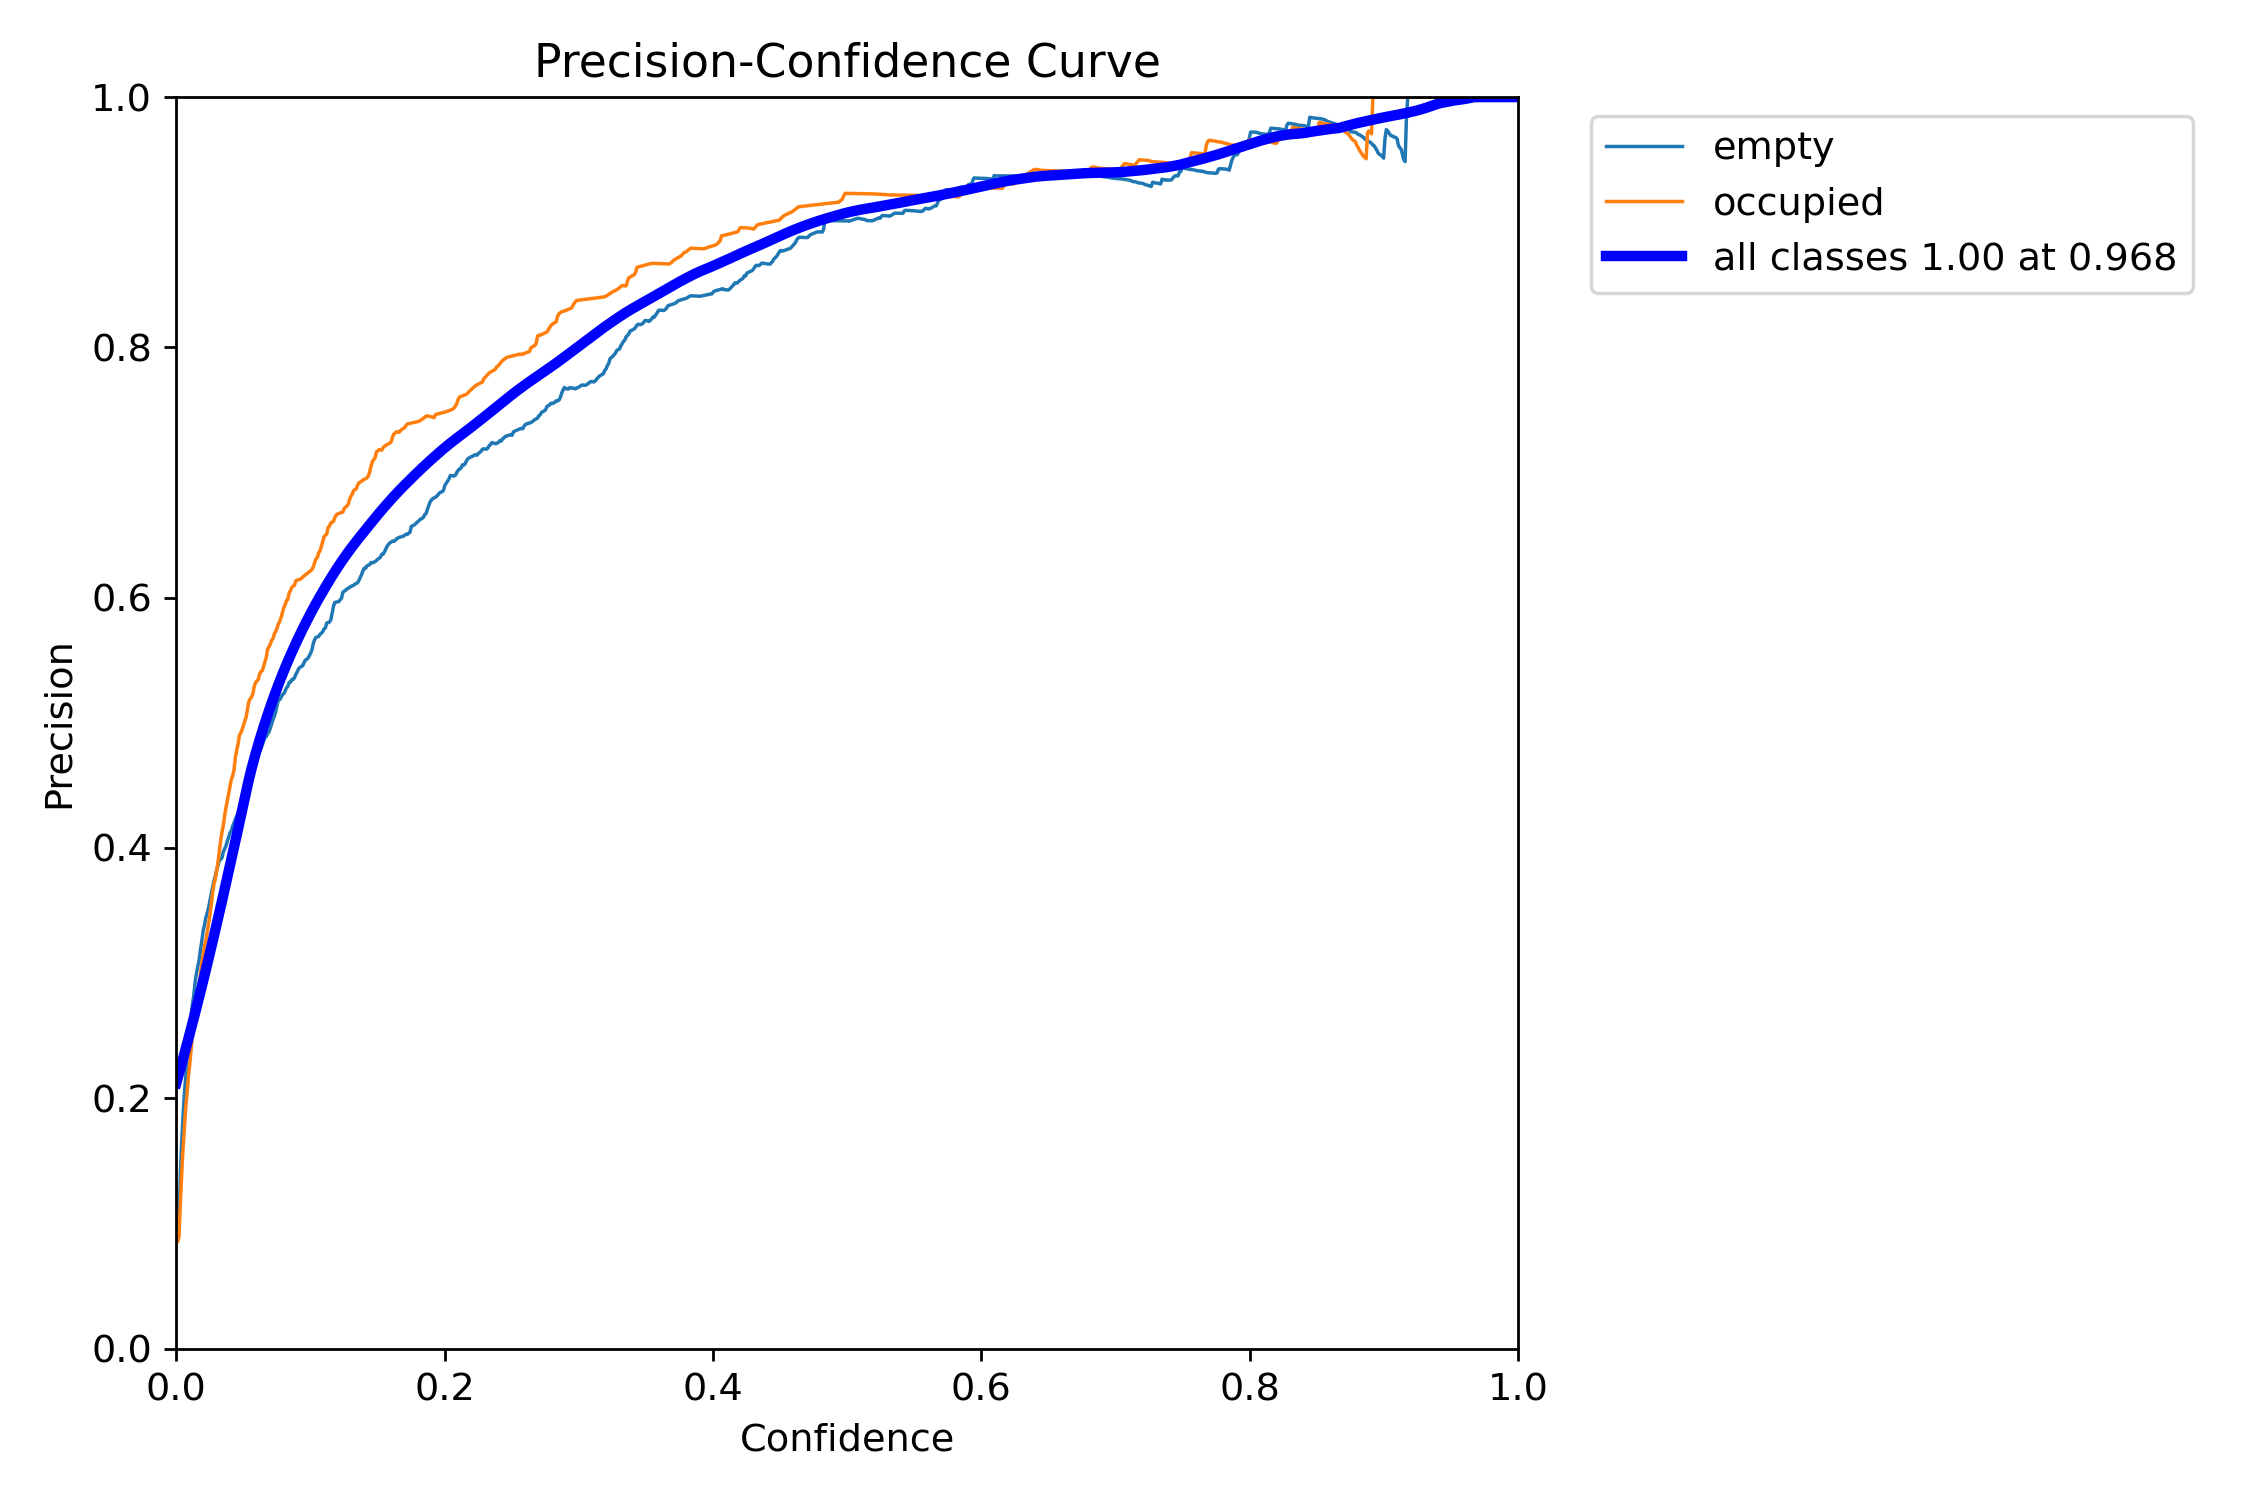

val_batch0_pred.jpg


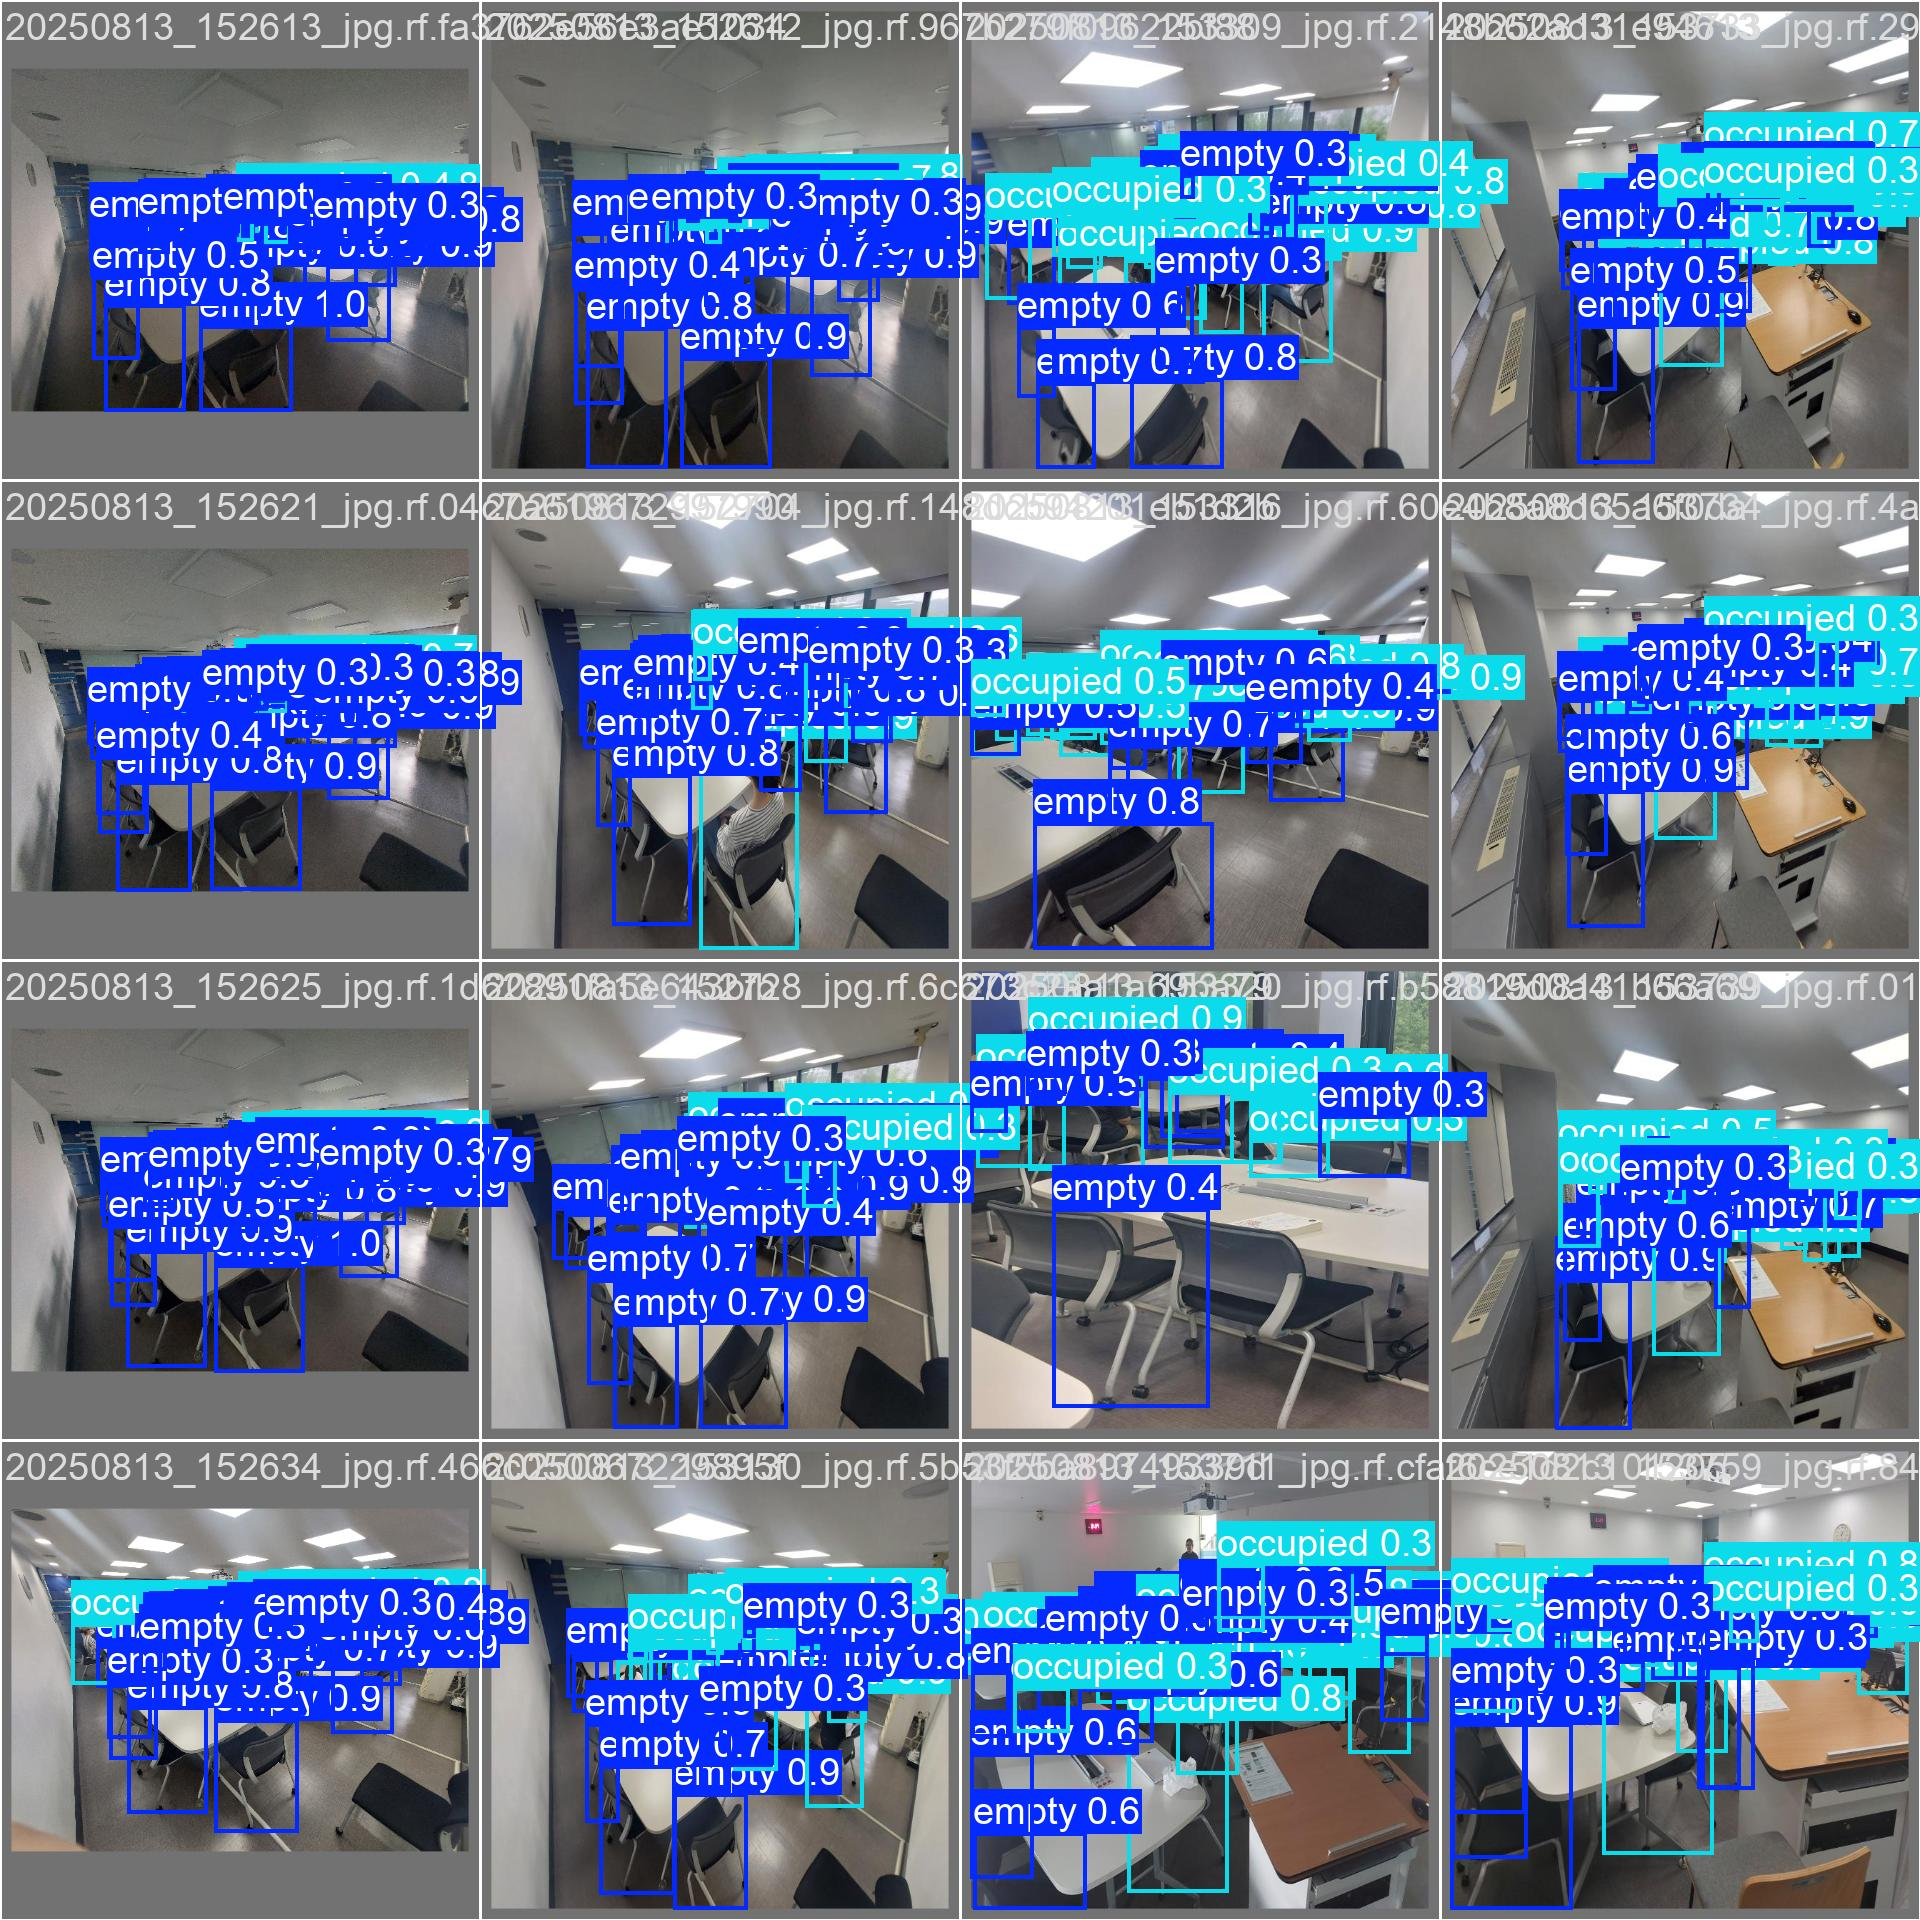

confusion_matrix_normalized.png


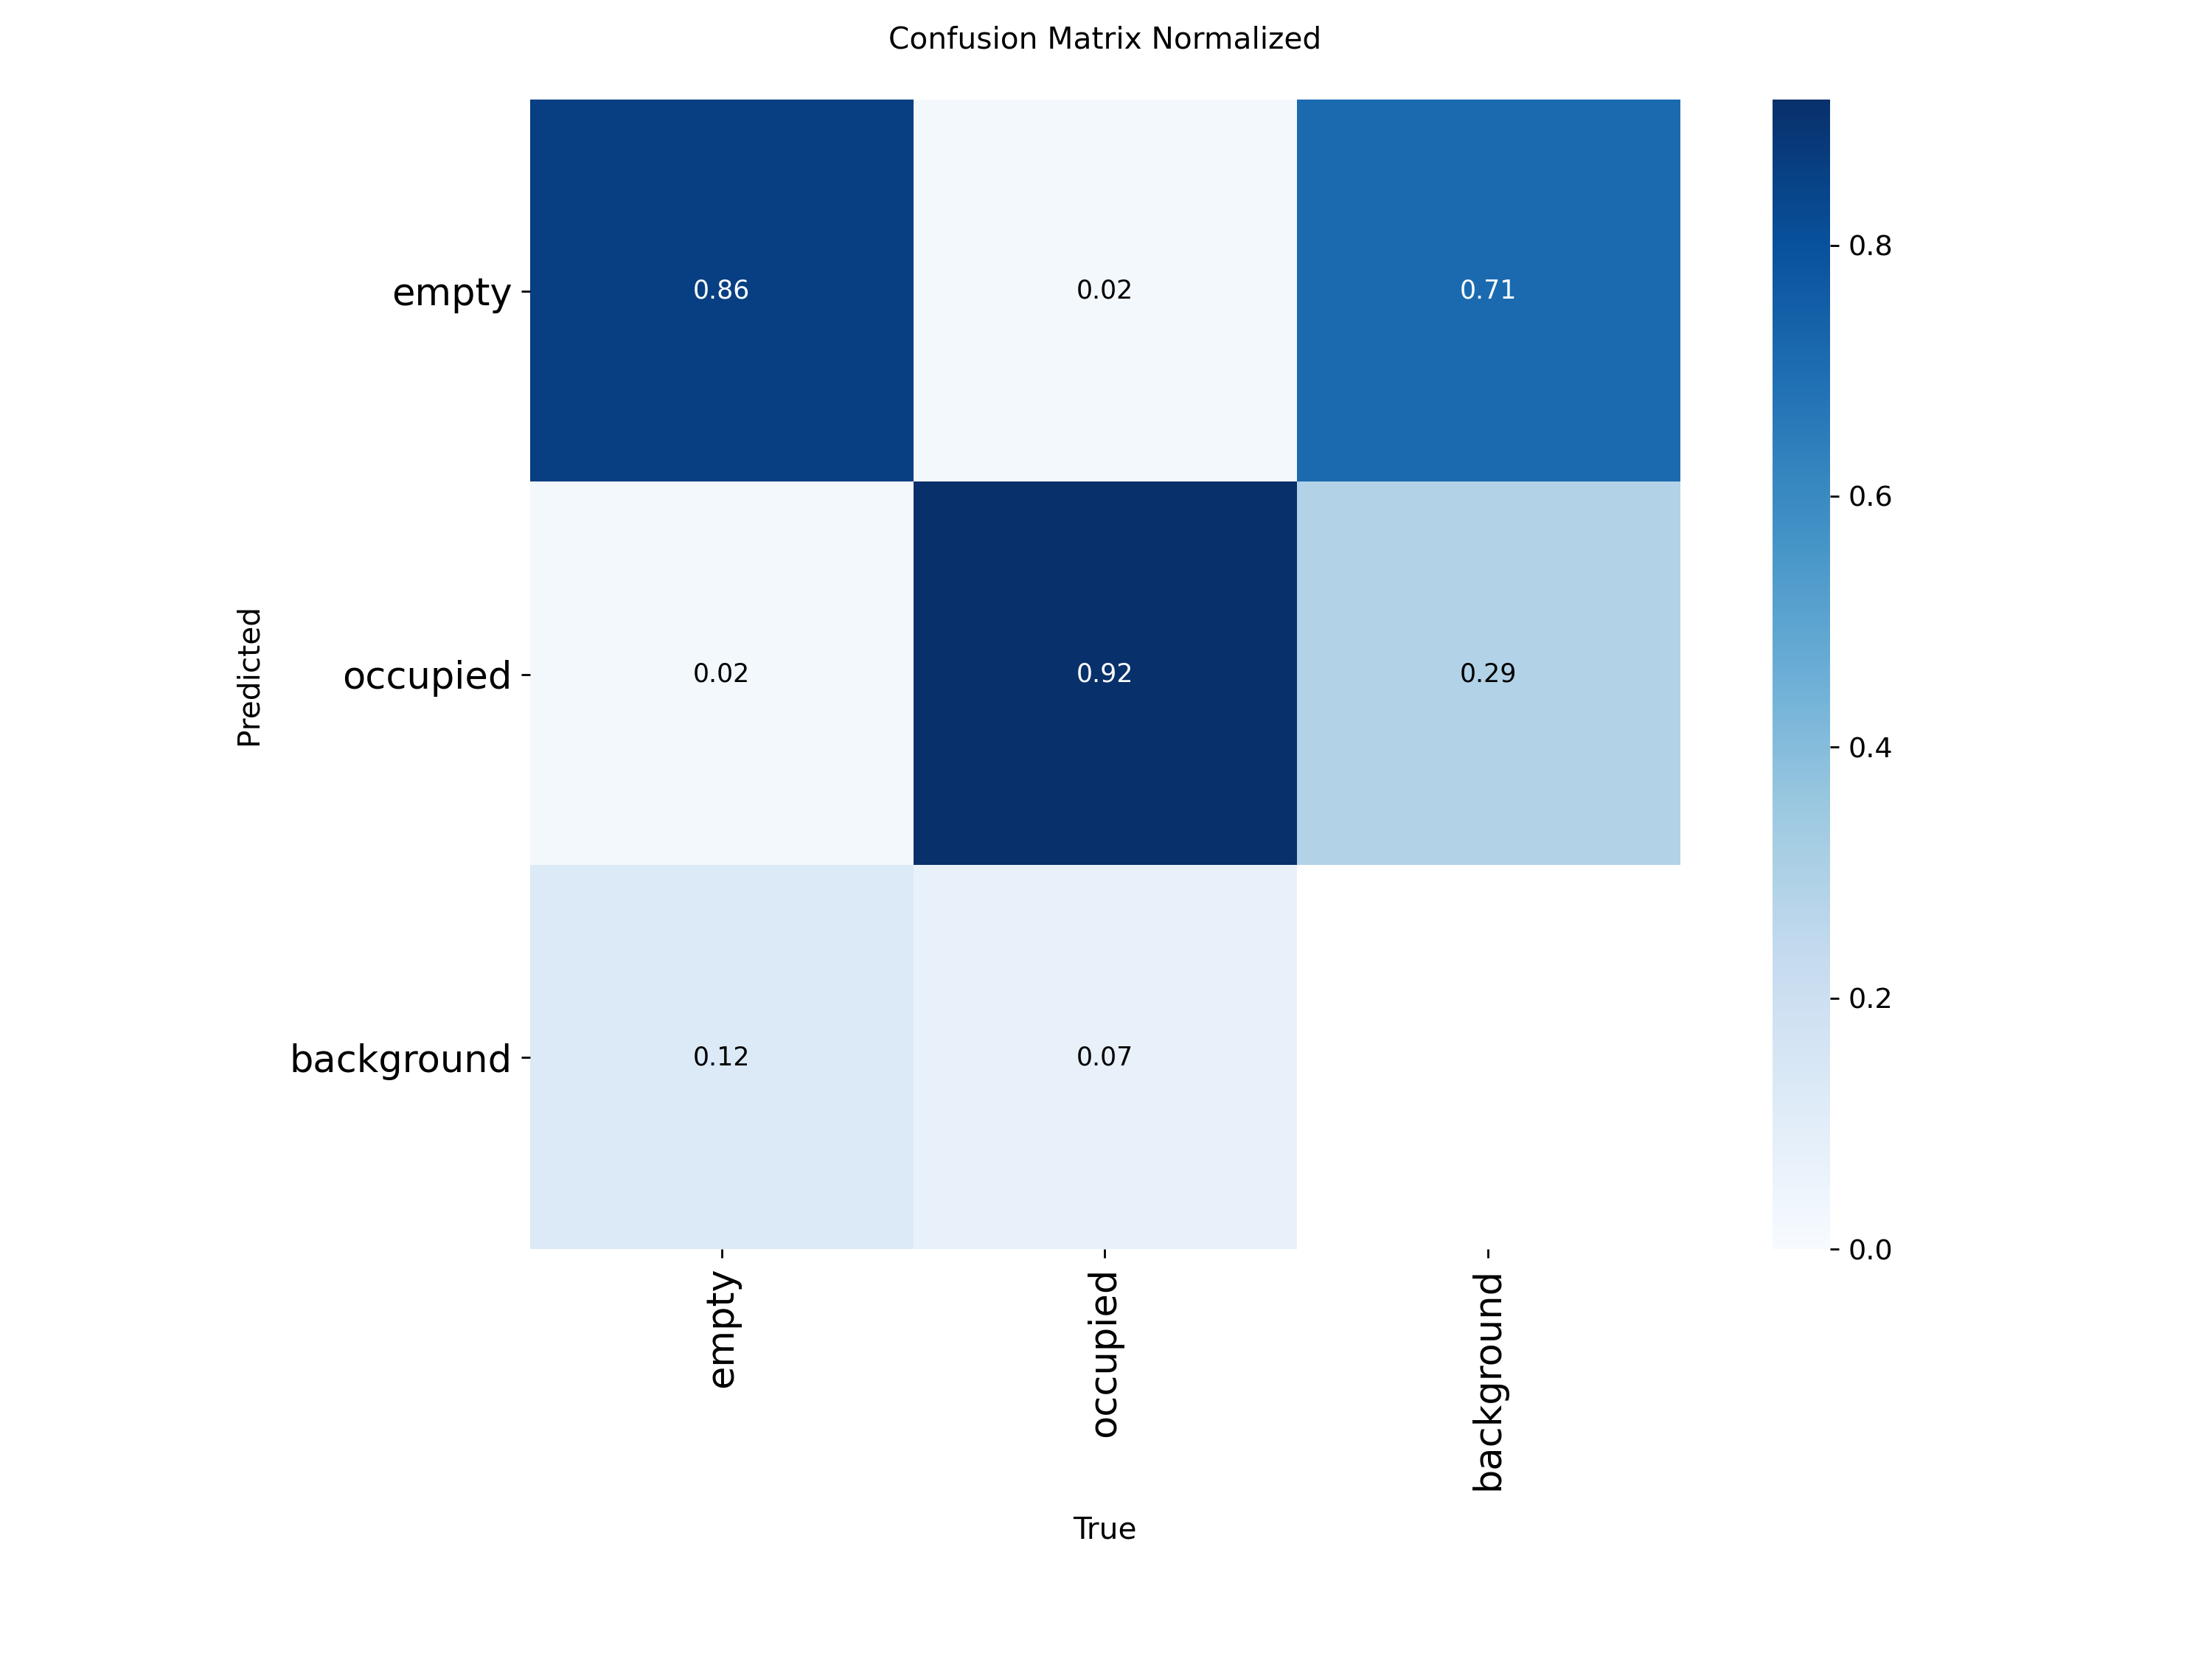

BoxF1_curve.png


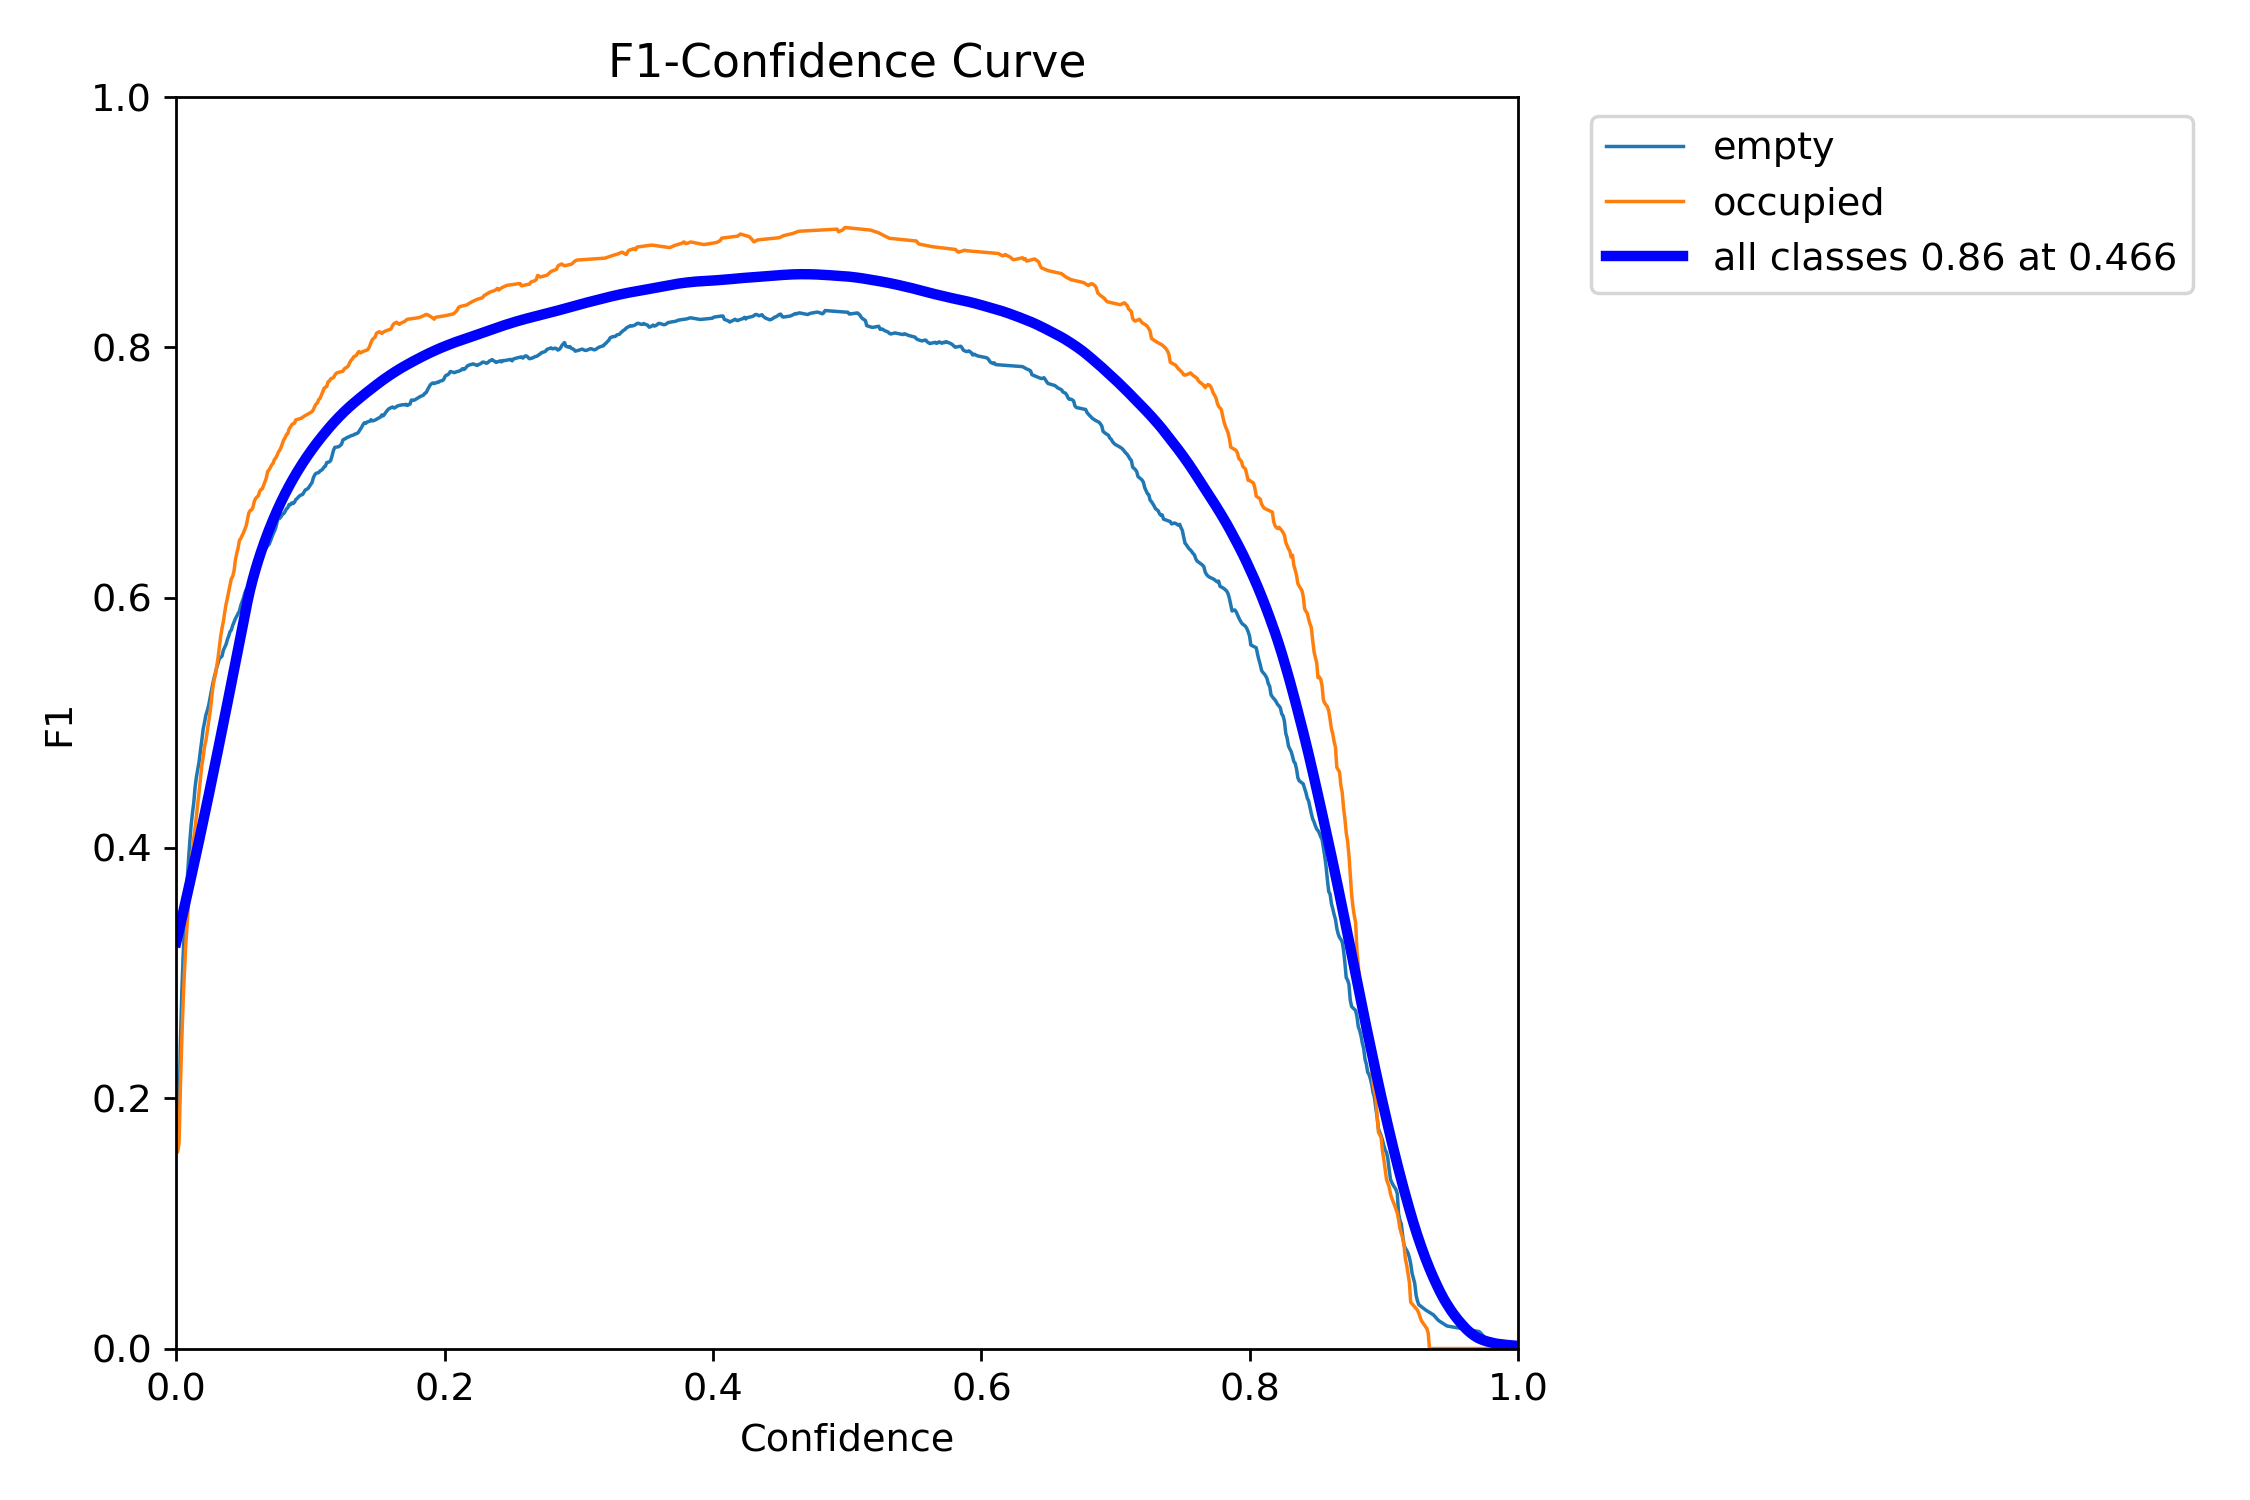

In [ ]:
import os
import random
import cv2
from google.colab.patches import cv2_imshow

# YOLO val 결과 이미지 경로
val_result_dir = "/content/runs/detect/val"

# 파일 리스트 불러오기
img_files = [f for f in os.listdir(val_result_dir) if f.endswith(('.jpg', '.png'))]

# 무작위 5장 선택
sample_imgs = random.sample(img_files, min(5, len(img_files)))

# 시각화
for f in sample_imgs:
    img_path = os.path.join(val_result_dir, f)
    img = cv2.imread(img_path)
    print(f"{f}")
    cv2_imshow(img)